In [1]:
# Import Statements
import numpy as np
import pandas as pd
import cv2
from glob import glob
import albumentations as A
import torch
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*COVID-19 CHEST X-RAY DATABASE (https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)

A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal and other lung infection dataset is released in stages. In the first release we have released 219 COVID-19, 1341 normal and 1345 viral pneumonia chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients.

**COVID-19 data:
COVID data are collected from different publicly accessible dataset, online sources and published papers.
-2473 CXR images are collected from padchest dataset[1].
-183 CXR images from a Germany medical school[2].
-559 CXR image from SIRM, Github, Kaggle & Tweeter[3,4,5,6]
-400 CXR images from another Github source[7].

***Normal images:
10192 Normal data are collected from from three different dataset.
-8851 RSNA [8]
-1341 Kaggle [9]

***Lung opacity images:
6012 Lung opacity CXR images are collected from Radiological Society of North America (RSNA) CXR dataset [8]

***Viral Pneumonia images:
1345 Viral Pneumonia data are collected from the Chest X-Ray Images (pneumonia) database [9]

Please cite the follwoing two articles if you are using this dataset:
-M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.
-Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. arXiv preprint arXiv:2012.02238.

**Reference:
[1]https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711
[2]https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png
[3]https://sirm.org/category/senza-categoria/covid-19/
[4]https://eurorad.org
[5]https://github.com/ieee8023/covid-chestxray-dataset
[6]https://figshare.com/articles/COVID-19_Chest_X-Ray_Image_Repository/12580328
[7]https://github.com/armiro/COVID-CXNet
[8]https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
[9] https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

**Formats - All the images are in Portable Network Graphics (PNG) file format and resolution are 299299 pixels.

****Objective
- Researchers can use this database to produce useful and impactful scholarly work on COVID-19, which can help in tackling this pandemic.

In [3]:

#Creating a base path to the dataset
base_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/"
image_metadata = pd.DataFrame()
image_metadata["Paths"] = glob(f"{base_path}*/*/*.png")
print(image_metadata["Paths"][1:4])


############################################################
# temp smaller dataset, delete once model has been created #
############################################################
temp_image_medatata = image_metadata.copy(deep=True)
temp_image_medatata = temp_image_medatata.iloc[1:5]
temp_image_medatata.head()

1    /content/drive/MyDrive/COVID-19_Radiography_Da...
2    /content/drive/MyDrive/COVID-19_Radiography_Da...
3    /content/drive/MyDrive/COVID-19_Radiography_Da...
Name: Paths, dtype: object


,Paths
1,/content/drive/MyDrive/COVID-19_Radiography_Da...
2,/content/drive/MyDrive/COVID-19_Radiography_Da...
3,/content/drive/MyDrive/COVID-19_Radiography_Da...
4,/content/drive/MyDrive/COVID-19_Radiography_Da...


In [4]:
#We can use the second asterix to identify if a mask or not, then the type of image from the name of the file itself
image_metadata[["Type", "File Name"]] = image_metadata["Paths"].str.extract(r'\/.*\/([a-z]+)\/(.*)')
image_metadata[["Classification Label", "ID #"]] = image_metadata["File Name"].str.extract(r'([aA-zZ].*)-([0-9].*)\.')
print(image_metadata.columns)


############################################################
# temp smaller dataset, delete once model has been created #
############################################################
temp_image_medatata = pd.DataFrame(columns=['Paths', 'Type', 'File Name', 'Classification Label', 'ID #'])
tempm = image_metadata[(image_metadata['Type'] == 'masks') & (image_metadata['Classification Label'] == 'Normal')].head(1)
tempi = image_metadata[(image_metadata['Type'] == 'images') & (image_metadata['Classification Label'] == 'Normal')].head(1)
tempm.head()
tempi.head()
pd.concat([tempm, tempi], ignore_index=True, axis=0)

Index(['Paths', 'Type', 'File Name', 'Classification Label', 'ID #'], dtype='object')


,Paths,Type,File Name,Classification Label,ID #
0,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9035.png,Normal,9035
1,/content/drive/MyDrive/COVID-19_Radiography_Da...,images,Normal-907.png,Normal,907


## Exploratory Data Analysis [Can Skip this until Model Code Portion]
- We probably need more graphs/charts here than just the pie chart

Lung Opacity - Non-COVID Lung Infection


([<matplotlib.patches.Wedge at 0x7890ec30a020>,
 [Text(0.06330145069282563, 1.0981770924309904, 'Normal'),
  Text(-0.7843116972641806, -0.7712685404802795, 'Lung_Opacity'),
  Text(0.6524920969340819, -0.8855812009288392, 'COVID'),
  Text(1.0781614818385268, -0.21810047932031737, 'Viral Pneumonia')],
 [Text(0.034528064014268514, 0.5990056867805401, '48%'),
  Text(-0.4278063803259166, -0.42069193117106146, '28%'),
  Text(0.35590478014586285, -0.48304429141573035, '17%'),
  Text(0.5880880810028327, -0.11896389781108219, '6%')])

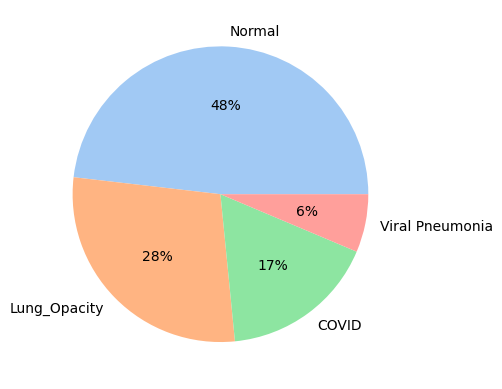

In [ ]:
#Distribution plot that shows # of covid 19, pneumonia images, and normal lung images
palette_color = sns.color_palette('pastel')
distrib = image_metadata["Classification Label"].value_counts()
plt.pie(distrib, colors=palette_color, labels=distrib.index, autopct="%.0f%%")

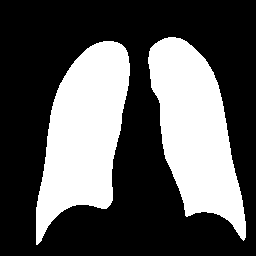

In [ ]:
#Populating a masked image
img = cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9047.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

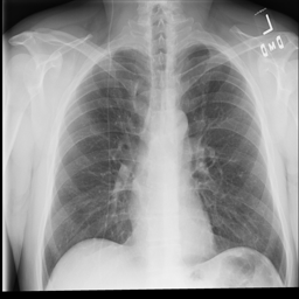

In [ ]:
#Populating the real image
img = cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9047.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

### Creating DataFrame with Images and Masks Together

In [5]:
#Populating the dataframe with both images and masks and their labels
images_df = image_metadata[image_metadata['Type'] == 'images'].reset_index()
images_df = images_df[['Paths', 'Classification Label', 'ID #']]
masks_df = image_metadata[image_metadata['Type'] == 'masks'].reset_index()
masks_df = masks_df[['Paths', 'Classification Label', 'ID #']]

merge_df = images_df.merge(masks_df, how='inner', on=['ID #', 'Classification Label'])
new_df = merge_df.rename(columns = {'Paths_x':'Images', 'Paths_y':'Masks'})
combined_df = new_df[['Images', 'Masks', 'Classification Label', 'ID #']]
combined_df

,Images,Masks,Classification Label,ID #
0,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,907
1,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9081
2,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9106
3,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9072
4,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9060
...,...,...,...,...
21160,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Lung_Opacity,101
21161,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Lung_Opacity,1008
21162,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Lung_Opacity,1002
21163,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Lung_Opacity,1014


### Visualizing the Different Classes of Lungs

In [ ]:
# Creating Separate Dataframe for Each Lung Type (For Reference)
df_normal_lungs = image_metadata[image_metadata['Classification Label'] == 'Normal'].reset_index()
df_viral_pneumonia = image_metadata[image_metadata['Classification Label'] == 'Viral Pneumonia'].reset_index()
df_covid = image_metadata[image_metadata['Classification Label'] == 'COVID'].reset_index()
df_lung_opacity = image_metadata[image_metadata['Classification Label'] == 'Lung_Opacity'].reset_index()

In [ ]:
df_normal_lungs

,index,Paths,Type,File Name,Classification Label,ID #
0,0,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9035.png,Normal,9035
1,1,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9047.png,Normal,9047
2,2,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9079.png,Normal,9079
3,3,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-905.png,Normal,905
4,4,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9078.png,Normal,9078
...,...,...,...,...,...,...
20389,20389,/content/drive/MyDrive/COVID-19_Radiography_Da...,images,Normal-10160.png,Normal,10160
20390,20390,/content/drive/MyDrive/COVID-19_Radiography_Da...,images,Normal-10156.png,Normal,10156
20391,20391,/content/drive/MyDrive/COVID-19_Radiography_Da...,images,Normal-10161.png,Normal,10161
20392,20392,/content/drive/MyDrive/COVID-19_Radiography_Da...,images,Normal-10168.png,Normal,10168


In [ ]:
# Creating Lists of Lung Masks to be Visualized based on the image paths
normal_masks = []
normal_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9047.png', cv2.IMREAD_UNCHANGED))
normal_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9035.png', cv2.IMREAD_UNCHANGED))
normal_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9079.png', cv2.IMREAD_UNCHANGED))
normal_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9078.png', cv2.IMREAD_UNCHANGED))

viral_pneumonia_masks = []
viral_pneumonia_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/Viral Pneumonia-1321.png', cv2.IMREAD_UNCHANGED))
viral_pneumonia_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/Viral Pneumonia-1306.png', cv2.IMREAD_UNCHANGED))
viral_pneumonia_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/Viral Pneumonia-1303.png', cv2.IMREAD_UNCHANGED))
viral_pneumonia_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/masks/Viral Pneumonia-174.png', cv2.IMREAD_UNCHANGED))

covid_masks = []
covid_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/masks/COVID-333.png', cv2.IMREAD_UNCHANGED))
covid_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/masks/COVID-3333.png', cv2.IMREAD_UNCHANGED))
covid_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/masks/COVID-3321.png', cv2.IMREAD_UNCHANGED))
covid_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/masks/COVID-3334.png', cv2.IMREAD_UNCHANGED))

lung_opacity_masks = []
lung_opacity_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/masks/Lung_Opacity-5542.png', cv2.IMREAD_UNCHANGED))
lung_opacity_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/masks/Lung_Opacity-5559.png', cv2.IMREAD_UNCHANGED))
lung_opacity_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/masks/Lung_Opacity-5550.png', cv2.IMREAD_UNCHANGED))
lung_opacity_masks.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/masks/Lung_Opacity-5523.png', cv2.IMREAD_UNCHANGED))

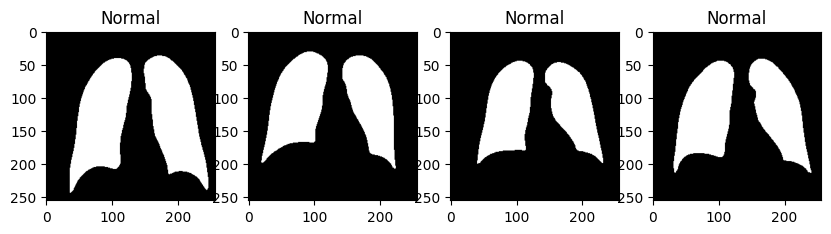

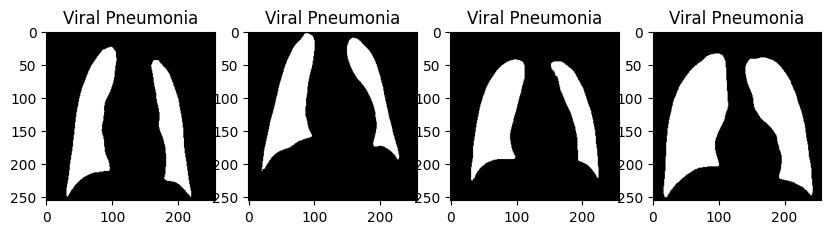

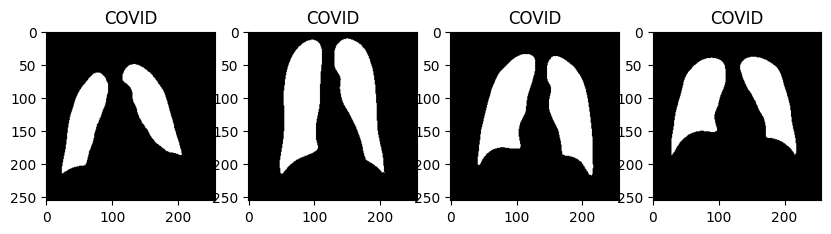

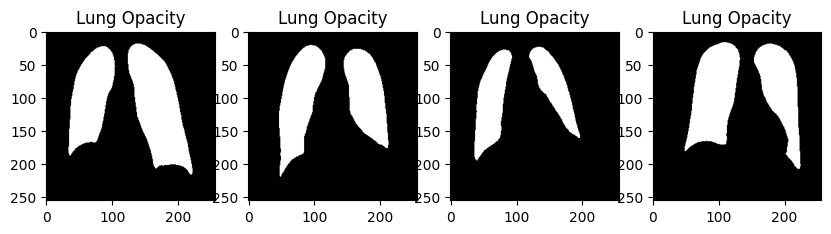

In [ ]:
# Plotting the Masks of the Lung Masks
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(normal_masks[i])
  ax.set_title('Normal')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(viral_pneumonia_masks[i])
  ax.set_title('Viral Pneumonia')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(covid_masks[i])
  ax.set_title('COVID')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(lung_opacity_masks[i])
  ax.set_title('Lung Opacity')

In [ ]:
# Creating Lists of Lung Images to be Visualized
normal_images = []
normal_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9047.png', cv2.IMREAD_UNCHANGED))
normal_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9035.png', cv2.IMREAD_UNCHANGED))
normal_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9079.png', cv2.IMREAD_UNCHANGED))
normal_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9078.png', cv2.IMREAD_UNCHANGED))

viral_pneumonia_images = []
viral_pneumonia_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1321.png', cv2.IMREAD_UNCHANGED))
viral_pneumonia_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1306.png', cv2.IMREAD_UNCHANGED))
viral_pneumonia_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1303.png', cv2.IMREAD_UNCHANGED))
viral_pneumonia_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-174.png', cv2.IMREAD_UNCHANGED))

covid_images = []
covid_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/COVID-333.png', cv2.IMREAD_UNCHANGED))
covid_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/COVID-3333.png', cv2.IMREAD_UNCHANGED))
covid_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/COVID-3321.png', cv2.IMREAD_UNCHANGED))
covid_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images/COVID-3334.png', cv2.IMREAD_UNCHANGED))

lung_opacity_images = []
lung_opacity_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5542.png', cv2.IMREAD_UNCHANGED))
lung_opacity_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5559.png', cv2.IMREAD_UNCHANGED))
lung_opacity_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5550.png', cv2.IMREAD_UNCHANGED))
lung_opacity_images.append(cv2.imread('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5523.png', cv2.IMREAD_UNCHANGED))

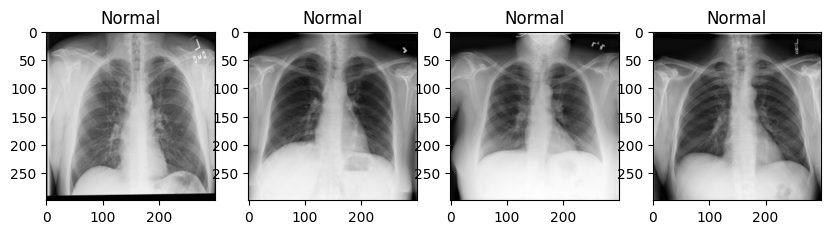

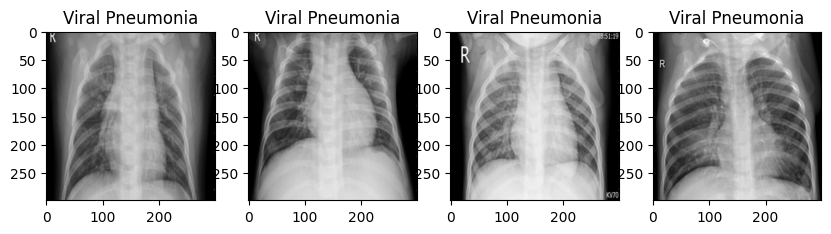

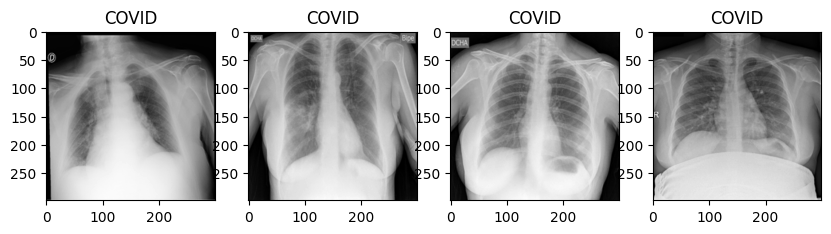

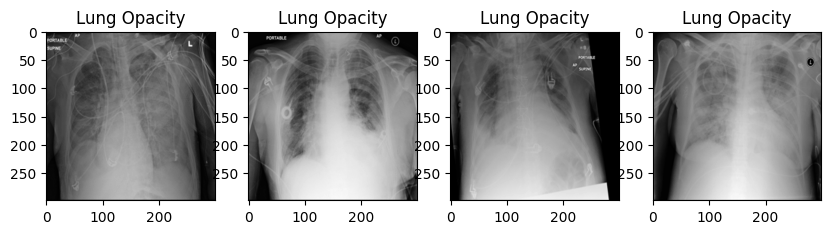

In [ ]:
# Plotting the original Lung Images
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(normal_images[i], cmap='gray')
  ax.set_title('Normal')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(viral_pneumonia_images[i], cmap='gray')
  ax.set_title('Viral Pneumonia')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(covid_images[i], cmap='gray')
  ax.set_title('COVID')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(lung_opacity_images[i], cmap='gray')
  ax.set_title('Lung Opacity')

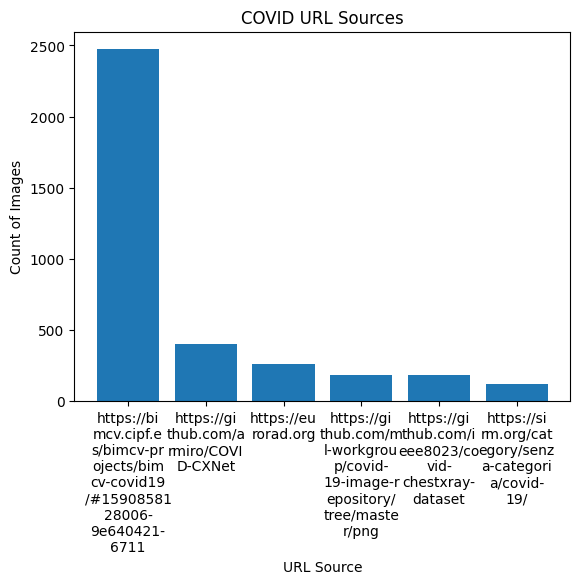

In [ ]:
#Reading in the metadata files
COVID_file_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID.metadata.xlsx"
COVIDdf = pd.read_excel(COVID_file_path)

#Populating the Covid URL stats
wrapped_labels = [textwrap.fill(url, width=10) for url,count in COVIDdf['URL'].value_counts().items()]
plt.bar(wrapped_labels, COVIDdf['URL'].value_counts())
plt.title("COVID URL Sources")
plt.xlabel("URL Source")
plt.ylabel("Count of Images");

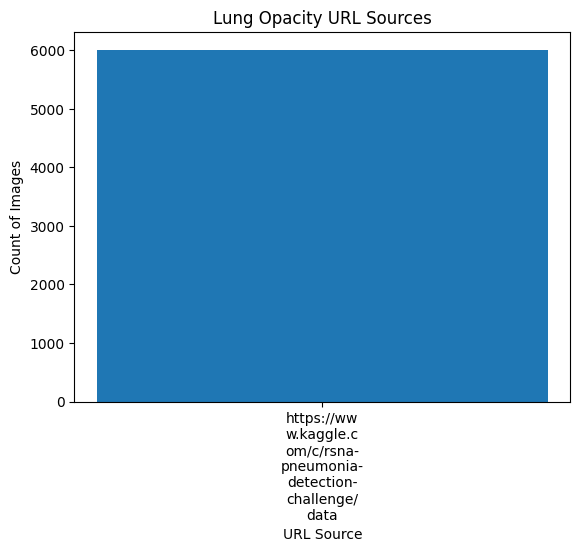

In [ ]:
#reading in meta file for lung opacity
LungOpacity_file_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx"
LungOpacitydf = pd.read_excel(LungOpacity_file_path)

#visualizing URL sources
wrapped_labels = [textwrap.fill(url, width=10) for url,count in LungOpacitydf['URL'].value_counts().items()]
plt.bar(wrapped_labels, LungOpacitydf['URL'].value_counts())
plt.title("Lung Opacity URL Sources")
plt.xlabel("URL Source")
plt.ylabel("Count of Images");

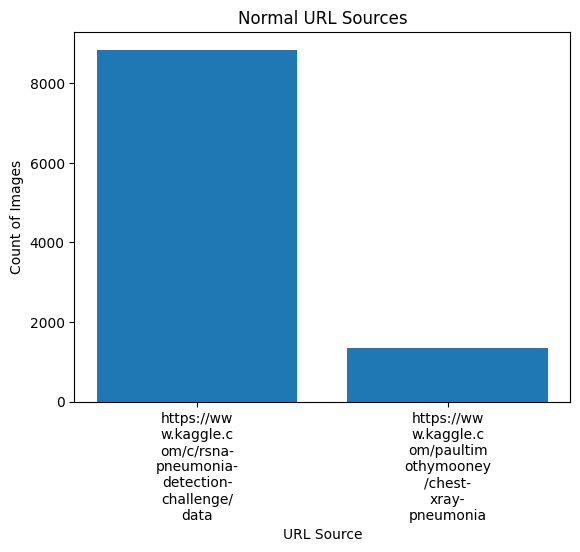

In [ ]:
#Populating the Normal image meta path
Normal_file_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal.metadata.xlsx"
Normaldf = pd.read_excel(Normal_file_path)

#visualizing url for normal lungs
wrapped_labels = [textwrap.fill(url, width=10) for url,count in Normaldf['URL'].value_counts().items()]
plt.bar(wrapped_labels, Normaldf['URL'].value_counts())
plt.title("Normal URL Sources")
plt.xlabel("URL Source")
plt.ylabel("Count of Images");

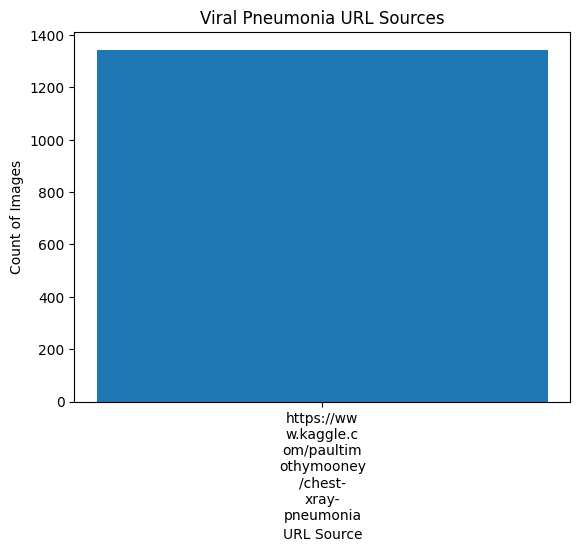

In [ ]:
#creating meta path for viral lungs
Viral_file_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx"
Viraldf = pd.read_excel(Viral_file_path)

#Populating the URL sources for viral lungs
wrapped_labels = [textwrap.fill(url, width=10) for url,count in Viraldf['URL'].value_counts().items()]
plt.bar(wrapped_labels, Viraldf['URL'].value_counts())
plt.title("Viral Pneumonia URL Sources")
plt.xlabel("URL Source")
plt.ylabel("Count of Images");

## Augmenting Dataset using Albumentations

In [ ]:
# edacountdf = pd.DataFrame(columns=['Lung Type', 'Image/Mask', 'Count'])
#Create two arrays of mask images and lung images by taking two subsets of the image_metadata df and reading from the list of paths contained therein
# images_df = image_metadata[image_metadata["Type"] == "images"].reset_index()
# masks_df = image_metadata[image_metadata["Type"] == "masks"].reset_index()


############################################################
# temp smaller dataset, delete once model has been created #
############################################################
temp_images_df = temp_image_medatata[temp_image_medatata["Type"] == "images"].reset_index()
temp_masks_df = temp_image_medatata[temp_image_medatata["Type"] == "masks"].reset_index()

temp_image_medatata.head()

,Paths,Type,File Name,Classification Label,ID #
1,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9047.png,Normal,9047
2,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9079.png,Normal,9079
3,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-905.png,Normal,905
4,/content/drive/MyDrive/COVID-19_Radiography_Da...,masks,Normal-9078.png,Normal,9078


In [ ]:
#Create images array by using the paths contained in the images_df to read each image in via cv2 package
# images = []
# masks = []
# for i in tqdm(range(len(images_df))):
#   image = cv2.imread(images_df["Paths"][i])
#   label = images_df["Type"][i]
#   images.append([image, label])

############################################################
# temp smaller dataset, delete once model has been created #
############################################################
temp_images = []
temp_masks = []
for i in tqdm(range(len(temp_images_df))):
  image = cv2.imread(temp_images_df["Paths"][i])
  label = temp_images_df["Type"][i]
  temp_images.append([image, label])

0it [00:00, ?it/s]


In [ ]:
#Repeat previous process for masks as well
for i in tqdm(range(len(masks_df))):
  mask = cv2.imread(masks_df["Paths"][i])
  label = masks_df["Type"][i]
  masks.append([mask, label])

 16%|█▌        | 3393/21175 [28:26<2:22:56,  2.07it/s]

In [ ]:
#cycle through these roots and folders to get counts for df:
# masks, images
# FOLDER_PATH = 'masks'
#COVID, Normal, Lung_Opacity, Viral Pneumonia
# ROOT_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia/'
# tempcount = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))
# edacountdf.loc[len(edacountdf.index)] = ['Viral Pneumonia', FOLDER_PATH, tempcount]

In [ ]:
# edacountdf

# Initial Model Implementation Notes

U-net model is based on fully convolution neural network, but pooling operations are substituted  out for upsampling operation, i.e, an encoder network then a decoder network. Upsampling means we restore the feature map to the original size of the input image and expand the dimensions of the feature map.
  - The encoder: CNN with transformer layer + dual attention blocks (these enable efficient skip connections)
  
  Skip connections are between encoder and decoder
  - Decoder:

https://huggingface.co/google/vit-base-patch16-224, we can use a pre-trained model through vision_transformer from google research
Need to enable skip connections
Softmax activation
256, 128, 64, 16 should be our decoder channel
patch size of 16 x 16 for the feature map
https://www.kaggle.com/code/odins0n/jax-flax-tf-data-vision-transformers-tutorial#-TPU-Setup-
Metrics:
Need DICE loss, cross entropy loss

In [ ]:
#Show dictionary of results
result_dict = {}
for index in images_df.index:
    result_dict[index] = (images_df.at[index, "Paths"], masks_df.at[index, "Paths"], images_df.at[index, "Classification Label"])

# result_dict

Split into train/test datasets but need to map the masks and images together once all data has been combined?

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #not sure if we should change the number of splits
# X=image data and Y=labels
# image_metadata["Classification Label"].value_counts()
keys=list(result_dict.keys())
X=list(map(int,keys))

for train_index, test_index in skf.split(X, [result_dict[key][2] for key in keys]):
    train_keys = [keys[i] for i in train_index]
    test_keys = [keys[i] for i in test_index]
    train_data = [result_dict[key] for key in train_keys]
    test_data = [result_dict[key] for key in test_keys]
train_keys[1:5]
test_keys[1:5]

train_data[1:4]

[('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9081.png',
  '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9047.png',
  'Normal'),
 ('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9106.png',
  '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9079.png',
  'Normal'),
 ('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-9072.png',
  '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-905.png',
  'Normal')]

In [ ]:
# print(image_metadata.keys())
# print("X_train length: ", len(X_train))
# print("X_test length: ", len(X_test))
# print("y_train length: ", len(y_train))
# print("y_test length: ", len(y_test))

In [ ]:
#Create list of transforms via albumentations (if they are out of order, possibly causes kernel crash on local instance of jupyter)
albumentation_transforms = [A.VerticalFlip(p = 1)
                            # , A.RandomBrightness(p = 1)
                            # , A.RandomContrast(limit = 0.6, p = 1) weirdly enough this causes the kernel to crash?
                            # , A.RandomCrop(p = 1, height = 220, width = 220)
                            # , A.Rotate(p = 1, limit = 90)
                            # , A.RGBShift(p = 1)
                           ]
# list of transforms found here https://albumentations.ai/docs/getting_started/transforms_and_targets/


In [ ]:
#Create list of transforms via albumentations (if they are out of order, possibly causes kernel crash on local instance of jupyter)
albumentation_transforms = [A.VerticalFlip(p = 1)
                            # , A.RandomBrightness(p = 1)
                            # , A.RandomContrast(limit = 0.6, p = 1) weirdly enough this causes the kernel to crash?
                            # , A.RandomCrop(p = 1, height = 220, width = 220)
                            # , A.Rotate(p = 1, limit = 90)
                            # , A.RGBShift(p = 1)
                           ]
# list of transforms found here https://albumentations.ai/docs/getting_started/transforms_and_targets/

transformed_masks = []
transformed_images = []
for transform in tqdm(albumentation_transforms):
    for entry in train_data:
        img = cv2.imread(entry[0])
        mask = cv2.imread(entry[1])
        transformed = transform(image=img, mask=mask)
        image_transform = transformed['image']
        mask_transform = transformed['mask']
        transformed_images.append(image_transform)
        transformed_masks.append(mask_transform)


print(len(transformed_images), len(transformed_masks))

100%|██████████| 1/1 [01:37<00:00, 97.48s/it]

16932 16932


### Reading in final_ds.csv

In [ ]:
# final_ds = pd.read_csv("/content/drive/MyDrive/COVID-19_Radiography_Dataset/final_ds.csv")

In [ ]:
# final_ds = pd.DataFrame({"image":transformed_images, 'masks':transformed_masks})

# Saving out the final dataset as a .csv file
# final_ds.to_csv('final_ds.csv')

In [ ]:
# final_ds.head(5)

,Unnamed: 0,image,masks
0,0,[[[ 41 41 41]\n [ 7 7 7]\n [ 0 0 ...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...
1,1,[[[ 14 14 14]\n [ 16 16 16]\n [ 17 17 ...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...
2,2,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...
3,3,[[[ 60 60 60]\n [ 49 49 49]\n [ 41 41 ...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...
4,4,[[[16 16 16]\n [18 18 18]\n [20 20 20]\n .....,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...


In [ ]:
result_dict = {}

for index in images_df.index:
    result_dict[index] = (images_df.at[index, 'Paths'], masks_df.at[index, 'Paths'])

print(result_dict)

# cv2_imshow(cv2.imread(), cv2.IMREAD_UNCHANGED)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(result_dict[0])

('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images/Normal-907.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/masks/Normal-9035.png')


In [ ]:
combined_df['image'] = combined_df['Images'].apply(lambda x: np.asarray(Image.open(x).resize((75,75))))
combined_df.head()

In [ ]:
# combined_df.to_csv("combined_df.csv")

In [ ]:
combined_df = pd.read_csv("/content/drive/MyDrive/COVID-19_Radiography_Dataset/combined_df.csv")

In [ ]:
combined_df.head()

,Unnamed: 0,Images,Masks,Classification Label,ID #,image
0,0,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,907,[[113 109 112 ... 86 41 18]\n [ 92 105 114 ...
1,1,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9081,[[ 7 6 5 ... 40 32 43]\n [ 6 6 5 ...
2,2,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9106,[[19 41 6 ... 13 6 2]\n [19 41 6 ... 26 17...
3,3,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9072,[[174 122 55 ... 75 77 86]\n [170 119 54 ...
4,4,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9060,[[197 170 154 ... 194 202 208]\n [ 71 22 14 ...


In [ ]:
# Removing the newline literals from the saved dataframe

import re

combined_df = combined_df.replace(r'\n','', regex=True)
combined_df.head()

,Unnamed: 0,Images,Masks,Classification Label,ID #,image
0,0,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,907,[[113 109 112 ... 86 41 18] [ 92 105 114 .....
1,1,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9081,[[ 7 6 5 ... 40 32 43] [ 6 6 5 .....
2,2,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9106,[[19 41 6 ... 13 6 2] [19 41 6 ... 26 17 ...
3,3,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9072,[[174 122 55 ... 75 77 86] [170 119 54 .....
4,4,/content/drive/MyDrive/COVID-19_Radiography_Da...,/content/drive/MyDrive/COVID-19_Radiography_Da...,Normal,9060,[[197 170 154 ... 194 202 208] [ 71 22 14 .....


### Test/Train Split

In [ ]:
# Subsetting the original larger dataset to test model code

tempm = combined_df[(combined_df['Classification Label'] == 'Viral Pneumonia')].head(10)
tempa = combined_df[combined_df['Classification Label'] == 'Normal'].head(10)
tempb = combined_df[combined_df['Classification Label'] == 'COVID'].head(10)
tempc = combined_df[combined_df['Classification Label'] == 'Lung_Opacity'].head(10)
tempf = pd.concat([tempa, tempb, tempc, tempm], ignore_index=True, axis=0)

tempf

# Modeling code in the Modeling notebook